In [1]:
using PorousMaterials
using PyPlot; const plt = PyPlot
using DataFrames
using CSV
#PyPlot.matplotlib.font_manager.fontManager.addfont("OpenSans-Regular.ttf") # installs font
PyPlot.matplotlib.style.use("grandbudapest.mplstyle") # uses style

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 14

xe_atomic_mass = read_atomic_masses()[:Xe] # in g / mol

131.293

In [2]:
path_to_exptl_isotherms = joinpath("data", "exptl_xe_isotherms")
path_to_sim_isotherms = joinpath("data","sim_xe_isotherms")

"data\\sim_xe_isotherms"

In [3]:
xtal_names = ["SBMOF-1", "CC3", "Ni-MOF-74", "HKUST-1", "SBMOF-2", "Co-formate",
                "MOF-505", "Activated-Carbon", "NiPyC2", "COF-103 (simulated)"]

xtal_to_marker = Dict("SBMOF-1" => "o", "CC3" => ">", "Ni-MOF-74" => "<", "HKUST-1" => "*", "SBMOF-2" => "H", 
    "Co-formate" => "^", "MOF-505" => "v",
    "Activated-Carbon" => "d", "NiPyC2" => "s", "COF-103 (simulated)" => "8")

xtal_to_color = Dict(zip(xtal_names, ["C$i" for i = 0:length(xtal_names)]))
xtal_to_marker

Dict{String,String} with 10 entries:
  "Ni-MOF-74"           => "<"
  "SBMOF-2"             => "H"
  "Activated-Carbon"    => "d"
  "CC3"                 => ">"
  "COF-103 (simulated)" => "8"
  "SBMOF-1"             => "o"
  "NiPyC2"              => "s"
  "HKUST-1"             => "*"
  "MOF-505"             => "v"
  "Co-formate"          => "^"

In [4]:
df_xtal = Dict{String, DataFrame}()

Dict{String,DataFrame} with 0 entries

In [5]:
# create a dictionary to store the xtal density values
ρ_xtal = Dict{String, Float64}()

# find xtal density using PorousMaterials.jl
for xtal_name in xtal_names
    if xtal_name != "Activated-Carbon"
        if xtal_name == "NiPyC2" || xtal_name == "COF-103 (simulated)"
            framework = Framework(xtal_name * ".cif")
            strip_numbers_from_atom_labels!(framework)
            ρ_xtal[string(xtal_name)] = crystal_density(framework) # kg/m³
        else    
            framework = Framework(xtal_name * ".cssr")
            strip_numbers_from_atom_labels!(framework)
            ρ_xtal[xtal_name] = crystal_density(framework) # kg/m³
        end
    else
        ρ_xtal[xtal_name] = 500.0 # kg/m³
    end
end

df_ρ_xtal = DataFrame(xtal=collect(keys(ρ_xtal)), ρ=collect(values(ρ_xtal)))
df_ρ_xtal[!, :color] = map(m -> xtal_to_color[m], df_ρ_xtal[:, :xtal])
sort!(df_ρ_xtal, :ρ)

# ρ_xtal # kg/m³

┌ Warning: Framework NiPyC2.cif has Pn space group. We are converting it to P1 symmetry for use in molecular simulations.
│         To afrain from this, pass `convert_to_p1=false` to the `Framework` constructor.
└ @ PorousMaterials C:\Users\Mel\.julia\packages\PorousMaterials\A6qqM\src\Crystal.jl:451


,xtal,ρ,color
,String,Float64,String
1,COF-103 (simulated),388.73,C9
2,Activated-Carbon,500.0,C7
3,HKUST-1,879.096,C3
4,MOF-505,926.618,C6
5,CC3,958.585,C1
6,SBMOF-2,1191.92,C4
7,Ni-MOF-74,1194.12,C2
8,NiPyC2,1250.33,C8
9,SBMOF-1,1570.4,C0


In [6]:
xe_isotherms = Dict{String, DataFrame}()

for xtal_name in xtal_names
    isotherm_filename = joinpath(path_to_exptl_isotherms, xtal_name, "Xe.csv")
    # some xtals have a hysteresis curve that needs to be removed from the data manually
    if xtal_name == "FMOF-Cu" 
        xe_isotherms[xtal_name] = CSV.read(isotherm_filename; copycols=true)
        deleterows!(xe_isotherms[xtal_name], 15:24)
    elseif xtal_name == "SBMOF-2"
        xe_isotherms[xtal_name] = CSV.read(isotherm_filename; copycols=true)
        deleterows!(xe_isotherms[xtal_name], 30:39)
    elseif xtal_name == "COF-103 (simulated)"
        sim_isotherm_filename = joinpath(path_to_sim_isotherms, xtal_name*".csv")
        cof_isotherm = CSV.read(sim_isotherm_filename; copycols=true)
        xe_isotherms[xtal_name] = cof_isotherm[:,[Symbol("pressure (bar)"), Symbol("⟨N⟩ (mmol/g)")]]
    else
        xe_isotherms[xtal_name] = CSV.read(isotherm_filename) 
    end
end

xe_isotherms["SBMOF-1"]

,P(mbar),Weight(mg),PercentMass
,Float64,Float64,Float64
1,0.063,36.4861,4.0e-6
2,0.222,36.4888,0.007839
3,0.398,36.51,0.066458
4,0.58,36.5438,0.159596
5,0.803,36.5881,0.281799
6,0.985,36.6281,0.392194
7,4.966,37.4443,2.64343
8,9.976,38.298,4.99974
9,19.99,39.4357,8.14745


In [7]:
# Define what the desired common units are for the data
common_pressure_units = Symbol("Pressure (bar)") 
common_loading_units = Symbol("Loading (mol/m³)")

# Define a dictionary with conversion factors.
pressure_conversion = Dict{Symbol, Float64}()
loading_conversion = Dict{Symbol, Float64}()

# pressure conversions to bar
pressure_conversion[Symbol("pressure (bar)")] = 1.0 # (1 bar) / (1 bar)
pressure_conversion[Symbol("P(bar)")] = 1.0 # (1 bar) / (1 bar)
# pressure_conversion[Symbol("fugacity (bar)")] = 1.0 # (1 bar) / (1 bar)
pressure_conversion[Symbol("P(mbar)")] = 1 / 1000 # (1 bar) / (1000 mbar)
pressure_conversion[Symbol("P(kPa)")] = 1 / 100 # (1 bar) / (100 kPa)
pressure_conversion[Symbol("P(torr)")] = 1 / 750.062 # (1 bar) / (750.062 torr)
pressure_conversion[Symbol("P(atm)")] = 1 / 0.986923 # (1 bar) / (0.986923 atm)
pressure_conversion[Symbol("P(mmHg)")] = 1 / 750

# loading conversions to mol/kg
# these conversion factors will put the quantity into mmol/g which can then be multiplied by the crystal density 
loading_conversion[Symbol("L(mmol/g)")] = 1.0 # (1 mol/kg) / (1 mmol/g)
loading_conversion[Symbol("⟨N⟩ (mmol/g)")] = 1.0 # (1 mol/kg) / (1 mmol/g)
loading_conversion[Symbol("L(ccSTP/g)")] = 1 / 22.4 # (cc STP /g) (1000 g /kg) (1 mol/ 22.4 L STP) (1 L / 1000 cc)
loading_conversion[Symbol("L(cm3STP/g)")] =1 / 22.4
# [(% mass) / 100 g Xe / g MOF](1 mol /MW_Xe g) (1000 g /1 kg)
loading_conversion[:PercentMass] = 1000.0 / xe_atomic_mass / 100.0
# this one is an exception where xtal density not needed
loading_conversion[Symbol("L(mol/L)")] = 1000.0 # (mol / L)(1000 L / m3)

1000.0

In [8]:
for xtal in keys(xe_isotherms)
    # loop over columns in the adsorption isotherm DataFrame
    for col_name in names(xe_isotherms[xtal])
        # convert pressure units to bar
        if col_name in keys(pressure_conversion)
            xe_isotherms[xtal][!, common_pressure_units] = xe_isotherms[xtal][!, col_name] * pressure_conversion[col_name]
        # convert loading units to mol/m3
        elseif col_name in keys(loading_conversion)
            if col_name == Symbol("L(mol/L)")
                xe_isotherms[xtal][!, common_loading_units] = xe_isotherms[xtal][!, col_name] * loading_conversion[col_name]
            else 
                xe_isotherms[xtal][!, common_loading_units] = xe_isotherms[xtal][!, col_name] * loading_conversion[col_name] * ρ_xtal[xtal] 
            end 
        else  
            print(xtal, " has units with unknown conversion: ",col_name,"\n") 
        end
    end
end


SBMOF-1 has units with unknown conversion: Weight(mg)
NiPyC2 has units with unknown conversion: P0
NiPyC2 has units with unknown conversion: p/p0
NiPyC2 has units with unknown conversion: Volume @ STP
NiPyC2 has units with unknown conversion: cc/g
NiPyC2 has units with unknown conversion: Column7
NiPyC2 has units with unknown conversion: Column8
NiPyC2 has units with unknown conversion: des P
NiPyC2 has units with unknown conversion: des P0
NiPyC2 has units with unknown conversion: des p/p0
NiPyC2 has units with unknown conversion: des Volume @ STP
NiPyC2 has units with unknown conversion: des cc/g
NiPyC2 has units with unknown conversion: des L(mmol/g)
NiPyC2 has units with unknown conversion: Column15


In [9]:
# fit Langmuir adsorption model
params_langmuir = Dict{String, Dict}()
for xtal in keys(xe_isotherms)
    params_langmuir[xtal] = fit_adsorption_isotherm(copy(xe_isotherms[xtal]), common_pressure_units,
        common_loading_units, :langmuir)
end

In [10]:
df_crystal = DataFrame(
                        xtal=xtal_names,
                        M_mol_m3=[params_langmuir[xtal]["M"] for xtal in xtal_names],
                        K_inv_bar=[params_langmuir[xtal]["K"] for xtal in xtal_names],
                        ρ_kg_m3=[ρ_xtal[xtal] for xtal in xtal_names]
                        )

CSV.write("df_crystal.csv", df_crystal)

df_crystal

,xtal,M_mol_m3,K_inv_bar,ρ_kg_m3
,String,Float64,Float64,Float64
1,SBMOF-1,2217.01,37.2343,1570.4
2,CC3,2630.2,7.57403,958.585
3,Ni-MOF-74,8546.38,1.51701,1194.12
4,HKUST-1,2622.07,2.04084,879.096
5,SBMOF-2,4426.9,3.2665,1191.92
6,Co-formate,4197.35,6.49703,1821.5
7,MOF-505,11464.2,0.975039,926.618
8,Activated-Carbon,2627.48,2.26493,500.0
9,NiPyC2,4130.24,18.9318,1250.33


In [11]:
const xtal_to_K = Dict(row.:xtal => row.:K_inv_bar for row in eachrow(df_crystal))
const xtal_to_M = Dict(row.:xtal => row.:M_mol_m3 for row in eachrow(df_crystal))
const xtal_to_ρ = Dict(row.:xtal => row.:ρ_kg_m3 for row in eachrow(df_crystal))

Dict{String,Float64} with 10 entries:
  "Ni-MOF-74"           => 1194.12
  "SBMOF-2"             => 1191.92
  "Activated-Carbon"    => 500.0
  "CC3"                 => 958.585
  "COF-103 (simulated)" => 388.73
  "SBMOF-1"             => 1570.4
  "NiPyC2"              => 1250.33
  "HKUST-1"             => 879.096
  "MOF-505"             => 926.618
  "Co-formate"          => 1821.5

### Ensuring validity of our simulations

Comparing simulations of SBMOF-1, NiPyC2, and COF-103 for justification of our usage of simulated data of COF-103 and ensure its accuracy with experimental isotherms.

In [12]:
sim_names = ["SBMOF-1", "NiPyC2", "COF-103 (simulated)"]

ρ_sim = Dict{String, Float64}()
for sim_name in sim_names
   if sim_name == "NiPyC2" || sim_name == "COF-103 (simulated)"
        framework = Framework(sim_name * ".cif")
        strip_numbers_from_atom_labels!(framework)
        ρ_sim[string(sim_name)] = crystal_density(framework) # kg/m³
    else    
        framework = Framework(sim_name * ".cssr")
        strip_numbers_from_atom_labels!(framework)
        ρ_sim[sim_name] = crystal_density(framework) # kg/m³
    end 
end
df_ρ_sim = DataFrame(xtal=collect(keys(ρ_sim)), ρ=collect(values(ρ_sim)))
sort!(df_ρ_sim, :ρ)

sim_isotherms = Dict{String, DataFrame}()
low_P_sim_isotherms = Dict{String, DataFrame}()

for sim_name in sim_names
    sim_filename = joinpath(path_to_sim_isotherms, sim_name * "_high_P.csv")
    low_P_sim_filename = joinpath(path_to_sim_isotherms, sim_name *"_low_P.csv")
    if sim_name == "COF-103 (simulated)"
        sim_filename = joinpath(path_to_sim_isotherms, sim_name * ".csv")
        sim_isotherm = CSV.read(sim_filename; copycols=true)
        sim_isotherms[sim_name] = CSV.read(sim_filename)
    else
        sim_isotherm = CSV.read(sim_filename; copycols=true)
        low_P_sim_isotherm = CSV.read(low_P_sim_filename; copycols=true)
        sim_isotherms[sim_name] = CSV.read(sim_filename)
        low_P_sim_isotherms[sim_name] = CSV.read(low_P_sim_filename)
    end
end

low_P_sim_isotherms["SBMOF-1"]

┌ Warning: Framework NiPyC2.cif has Pn space group. We are converting it to P1 symmetry for use in molecular simulations.
│         To afrain from this, pass `convert_to_p1=false` to the `Framework` constructor.
└ @ PorousMaterials C:\Users\Mel\.julia\packages\PorousMaterials\A6qqM\src\Crystal.jl:451


,pressure (bar),fugacity (bar),⟨N⟩ (mmol/g)
,Float64,Float64,Float64
1,0.0,0.0,0.0
2,0.001,0.000999994,0.228191
3,0.00163789,0.00163788,0.369017
4,0.0026827,0.00268265,0.532818
5,0.00439397,0.00439385,0.727989
6,0.00719686,0.00719655,0.92472
7,0.0117877,0.0117868,1.09638
8,0.019307,0.0193047,1.2165
9,0.0316228,0.0316168,1.32195


In [13]:
for xtal in keys(low_P_sim_isotherms)
    # loop over columns in the adsorption isotherm DataFrame
    for col_name in names(low_P_sim_isotherms[xtal])
        # convert pressure units to bar
        if col_name in keys(pressure_conversion)
            low_P_sim_isotherms[xtal][!, common_pressure_units] = low_P_sim_isotherms[xtal][!, col_name] * pressure_conversion[col_name]
        # convert loading units to mol/m3
        elseif col_name in keys(loading_conversion)
            if col_name == Symbol("L(mol/L)")
                low_P_sim_isotherms[xtal][!, common_loading_units] = low_P_sim_isotherms[xtal][!, col_name] * loading_conversion[col_name]
            else 
                low_P_sim_isotherms[xtal][!, common_loading_units] = low_P_sim_isotherms[xtal][!, col_name] * loading_conversion[col_name] * ρ_xtal[xtal] 
            end 
        else  
            print(xtal, " has units with unknown conversion: ",col_name,"\n") 
        end
    end
end


SBMOF-1 has units with unknown conversion: fugacity (bar)
NiPyC2 has units with unknown conversion: fugacity (bar)


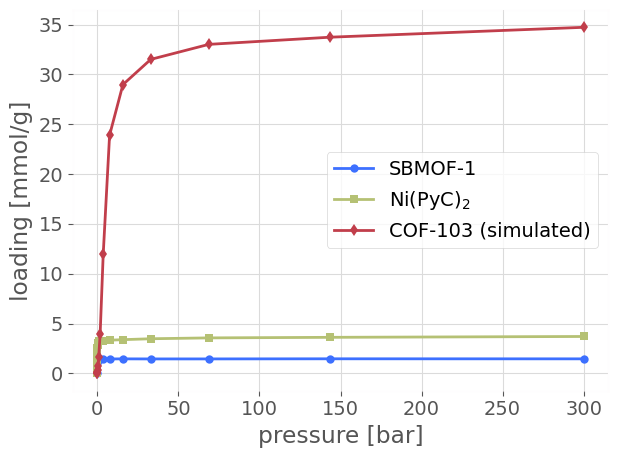

In [99]:
# All simulated data together.
figure()
sim_to_marker = Dict(zip(sim_names, ["o", "s", "d"]))
for sim in sim_names
    if sim == "COF-103_simulated"
        plot(sim_isotherms[sim][:, Symbol("pressure (bar)")], 
         sim_isotherms[sim][:, Symbol("⟨N⟩ (mmol/g)")], 
        label="COF-103 (simulated)", marker=sim_to_marker[sim], 
        color=xtal_to_color[sim])
    else
        plot(sim_isotherms[sim][:, Symbol("pressure (bar)")], 
         sim_isotherms[sim][:, Symbol("⟨N⟩ (mmol/g)")], 
        label=(sim == "NiPyC2" ? L"Ni(PyC)$_2$" : sim), marker=sim_to_marker[sim], zorder=500,
        color=xtal_to_color[sim])
    end
    savefig("figures/simulations/")
end
legend()
xlabel("pressure [bar]")
ylabel("loading [mmol/g]")
tight_layout()
# savefig("figures/simulations/simulations_COF-103_sat.pdf")

In [77]:
function simulation_validity(sim::String)
    figure()
        # experimental data
    scatter(xe_isotherms[sim][Symbol("Pressure (bar)")], xe_isotherms[sim][Symbol("Loading (mol/m³)")],
    color=xtal_to_color[sim], label="experimental", marker=sim_to_marker[sim])
    # simulation data
    plot(low_P_sim_isotherms[sim][:, Symbol("pressure (bar)")], 
         low_P_sim_isotherms[sim][:, Symbol("Loading (mol/m³)")], 
        color="red", label="simulation", marker=">")
    legend()
    xlabel(L"pressure, $P$ [bar]")
    ylabel("loading [mol/m³]")
    title(sim == "NiPyC2" ? L"Ni(PyC)$_2$" : sim)
    tight_layout()
    savefig(string("figures/simulations/" * sim * "_simulations_comparison.pdf"))
end

simulation_validity (generic function with 1 method)

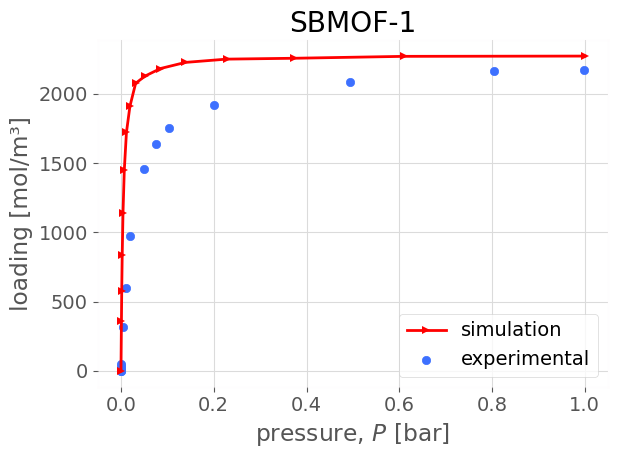

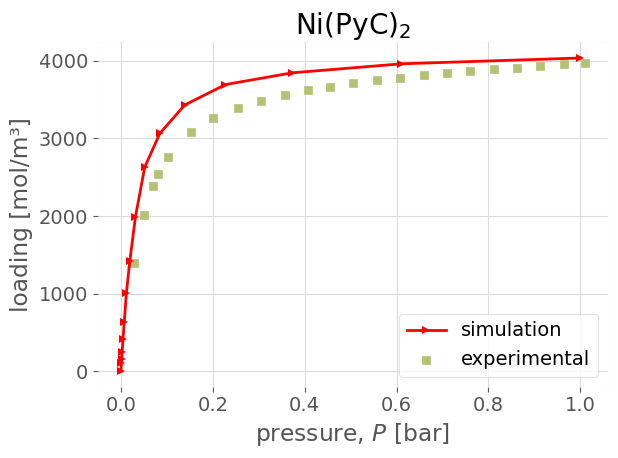

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = simulation_validity(::String) at In[77]:4
└ @ Main .\In[77]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = simulation_validity(::String) at In[77]:4
└ @ Main .\In[77]:4


In [78]:
for sim in ("SBMOF-1", "NiPyC2")
    simulation_validity(sim)
end

### Finding xenon data

In [102]:
wheres_nist_xenon_data = joinpath("data", "NIST_data", "xenon_NIST_data.txt")

df_xe_data = CSV.read(wheres_nist_xenon_data)
# we want higher resolution data at low pressures for doing comparisons with the experimental isotherm data
df_low_p_xe_data = CSV.read(joinpath("data", "NIST_data", "low_pressure_xenon_NIST_data.txt"))

# source: NIST 
const xe_critical_pressure = 58.420 # bar

# put density in units we're working with (mol/m³)
insertcols!(df_xe_data, 3, density_mol_m3=df_xe_data[:, Symbol("Density (mol/l)")] * 1000.0)
rename!(df_xe_data, :density_mol_m3 => Symbol("Density (mol/m³)"))

insertcols!(df_low_p_xe_data, 3, density_mol_m3=df_low_p_xe_data[:, Symbol("Density (mol/l)")] * 1000.0)
rename!(df_low_p_xe_data, :density_mol_m3 => Symbol("Density (mol/m³)"))

first(df_xe_data, 5)

const pressures = df_xe_data[:, Symbol("Pressure (bar)")][2:end] # bar
const low_pressures = df_low_p_xe_data[:, Symbol("Pressure (bar)")][2:end] # bar

const ρ_xe = df_xe_data[:, Symbol("Density (mol/m³)")][2:end]; # mol/m³
const low_ρ_xe = df_low_p_xe_data[:, Symbol("Density (mol/m³)")][2:end]; # mol/m³

## viz material space

### material densities of xtals

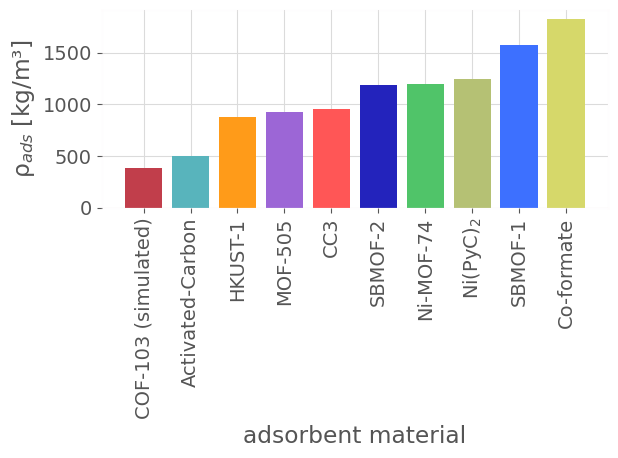

In [79]:
figure()
xlabel("adsorbent material")
ylabel(L"ρ$_{ads}$ [kg/m³]")
bar(1:nrow(df_ρ_xtal), df_ρ_xtal[:, :ρ], color=df_ρ_xtal[:, :color])
xticks(1:nrow(df_ρ_xtal), replace(df_ρ_xtal[:, :xtal], "NiPyC2" => L"Ni(PyC)$_2$"), rotation="vertical")
tight_layout()
savefig("figures/material_densities.pdf")

### langmuir density correlations

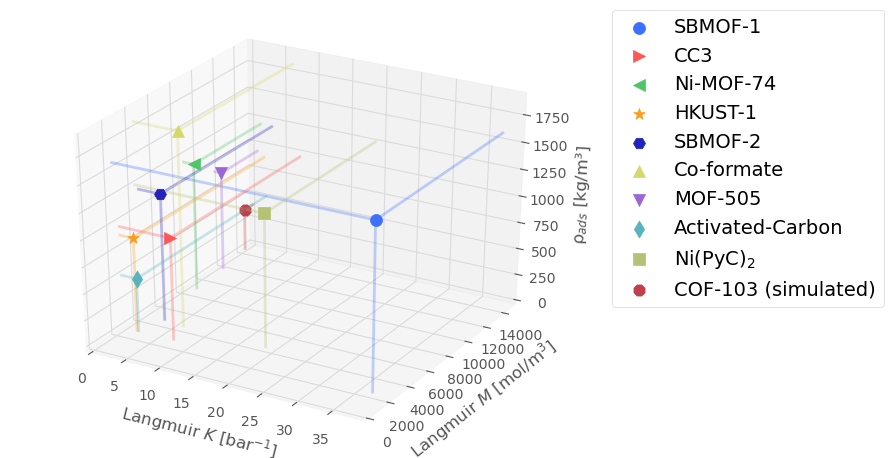

sys:1: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
sys:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


In [80]:
figure()
title("material Space")

for row in eachrow(df_crystal)
    x = [row[:K_inv_bar], row[:M_mol_m3], row[:ρ_kg_m3]]
    scatter3D(x..., 
        label=(row[:xtal] == "NiPyC2" ? L"Ni(PyC)$_2$" : row[:xtal]), marker=xtal_to_marker[row[:xtal]], s=75, 
        color=xtal_to_color[row[:xtal]]
#        color=row[:xtal] == "COF-103 (simulated)" ? "none" : xtal_to_color[row[:xtal]]
              )
end 

for row in eachrow(df_crystal)
    x = [row[:K_inv_bar], row[:M_mol_m3], row[:ρ_kg_m3]]
    for k = 1:3
        x_projected = copy(x)
        if k == 2
            x_projected[k] = 15000
        else
            x_projected[k] = 0
        end
        plot(
            [x_projected[1], x[1]], 
            [x_projected[2], x[2]], 
            [x_projected[3], x[3]], 
            color=xtal_to_color[row[:xtal]], alpha=0.3
            )
    end
end

xlabel(L"Langmuir $K$ [bar$^{-1}$]", labelpad=6, fontsize=12)
ylabel(L"Langmuir $M$ [mol/m$^3$]", labelpad=6, fontsize=12)
zlabel(L"ρ$_{ads}$ [kg/m³]", labelpad=6, fontsize=12)

tick_params(labelsize=10)
ylim(0.0, 15000)
xlim(left=0.0)
zlim(bottom=0.0)
legend(bbox_to_anchor=(1.05, 1), borderaxespad=0, fontsize=14)
tight_layout()
savefig("figures/material_space.pdf", bbox_inches="tight")

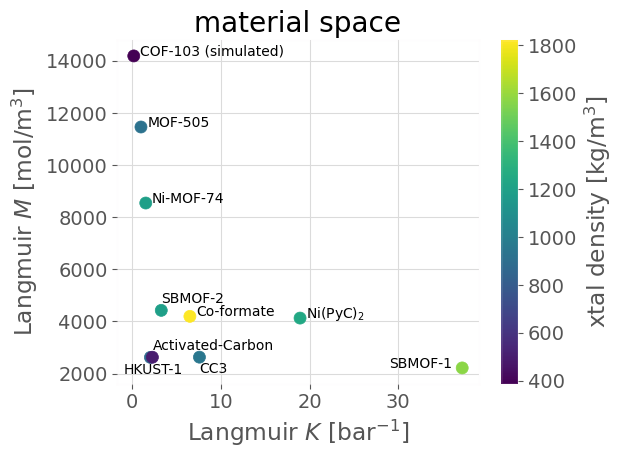

In [106]:
K = df_crystal[:, :K_inv_bar]
M = df_crystal[:, :M_mol_m3]

figure()
title("material space")
scatter(K, M, c=df_crystal[:, :ρ_kg_m3], marker="o", s=75, clip_on=false)

xtal_to_text_pos = Dict(xtal => [0.7, 0.7] for xtal in xtal_names)
xtal_to_text_pos["SBMOF-1"] = [-8.3, 0]
xtal_to_text_pos["SBMOF-2"] = [0, 300]
xtal_to_text_pos["FMOF-Cu"] = [-1, 500]
xtal_to_text_pos["Activated-Carbon"] = [0, 270]
xtal_to_text_pos["HKUST-1"] = [-3, -650]
xtal_to_text_pos["CC3"] = [0, -600]

for i = 1:length(xtal_names)
    text(
        K[i]+xtal_to_text_pos[xtal_names[i]][1], M[i]+xtal_to_text_pos[xtal_names[i]][2],
        (xtal_names[i] == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal_names[i]), fontsize=10
        )
end

xlabel(L"Langmuir $K$ [bar$^{-1}$]")
ylabel(L"Langmuir $M$ [mol/m$^3$]")
colorbar(label=L"xtal density [kg/m$^3$]")
tight_layout()
savefig("figures/material_space_color_bar.pdf", bbox_inches="tight")

## viz Langmuir fits

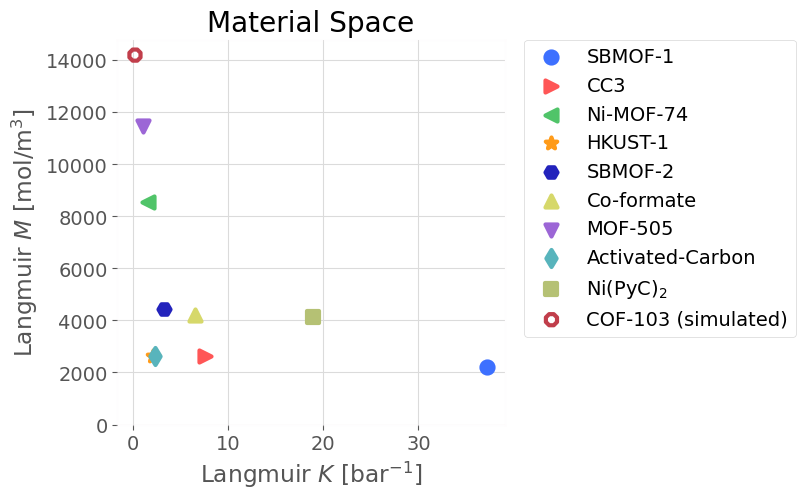

In [81]:
figure(figsize=(5,5))
title("Material Space")
for xtal in xtal_names
    scatter(xtal_to_K[xtal], xtal_to_M[xtal], 
        label=(xtal == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal), marker=xtal_to_marker[xtal], s=75, clip_on=false, 
        color=xtal == "COF-103 (simulated)" ? "none" : xtal_to_color[xtal], 
        edgecolor=xtal_to_color[xtal], lw=3)
end
xlabel(L"Langmuir $K$ [bar$^{-1}$]")
ylabel(L"Langmuir $M$ [mol/m$^3$]")
ylim(ymin=0.0)
# xlim(xmin=0.0)
legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
savefig("figures/material_space_langmuir.pdf", bbox_inches="tight")

In [103]:
function plot_xtal_langmuir_fit(xtal::String, max_pressure::Float64)
    
    # fitting plot
    figure()
    xlabel(L"pressure, $P$ [bar]")
    ylabel("ρₓₑ [mol / m\$^3\$]")
    title(xtal == "NiPyC2" ? L"Ni(PyC)$_2$" : xtal)
    label="experiment"
    if xtal == "COF-103 (simulated)"
        label="simulation"
    end
    scatter(xe_isotherms[xtal][:, common_pressure_units], xe_isotherms[xtal][:, common_loading_units],
        color=xtal_to_color[xtal], label=label)
    
    # Langmuir fit
    pressure_low = range(0.0, stop=max_pressure, length=500) # check with COF-103
    ρ_langmuir = (params_langmuir[xtal]["M"] .* params_langmuir[xtal]["K"] .* pressure_low) ./ (
                    1 .+ params_langmuir[xtal]["K"] * pressure_low)
    plot(pressure_low, ρ_langmuir, color=xtal_to_color[xtal], label="Langmuir fit", linewidth=3, alpha=0.4)
    
    # bulk gas density
    if max_pressure < 1.0
        plot(df_low_p_xe_data[:, Symbol("Pressure (bar)")], df_low_p_xe_data[:, Symbol("Density (mol/m³)")], 
            label="bulk gas", linestyle="--", color="gray")
            xlim(xmax=1.05)
    else 
        max_index = findfirst(df_xe_data[:, Symbol("Pressure (bar)")] .> max_pressure) # find the index of the max pressure in the dataframe
        plot(df_xe_data[1:max_index, Symbol("Pressure (bar)")], df_xe_data[1:max_index, Symbol("Density (mol/m³)")], 
            label="bulk gas", linestyle="--", color="gray")
    end
    
    grid("on")
    legend()
    tight_layout()
    
      if max_pressure < 1.5
         savefig(string("figures/langmuir/low_P_langmuir_fit_", xtal, ".pdf"), bbox_inches="tight")
      else
         savefig(string("figures/langmuir/high_P_langmuir_fit_", xtal, ".pdf"), bbox_inches="tight")
      end

end

plot_xtal_langmuir_fit (generic function with 1 method)

### Low pressure fit

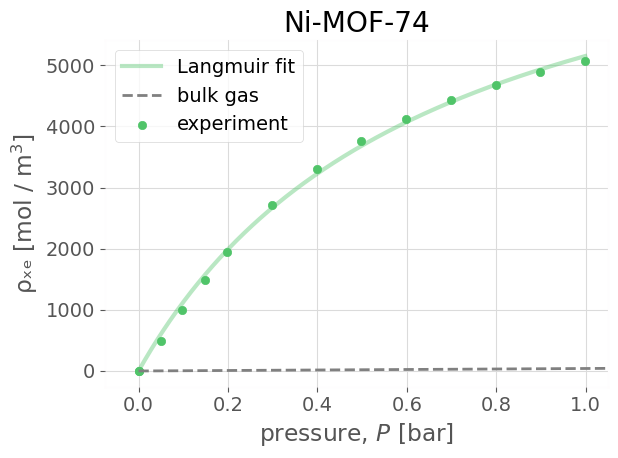

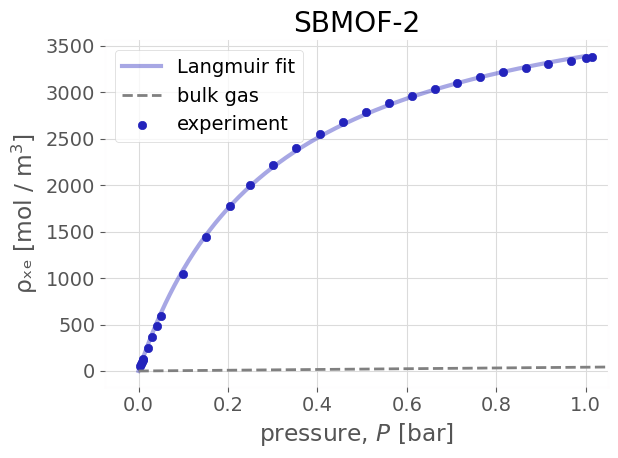

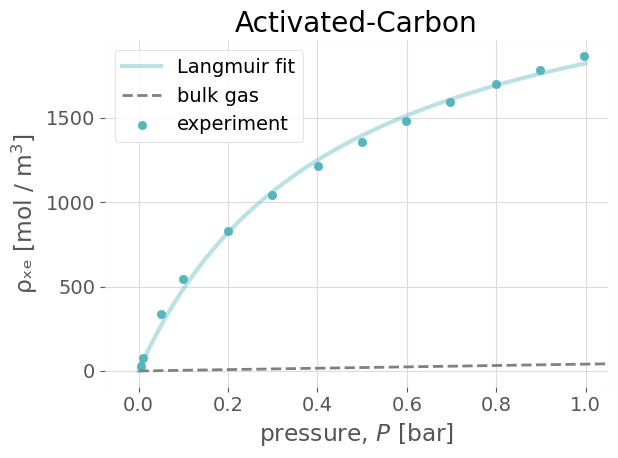

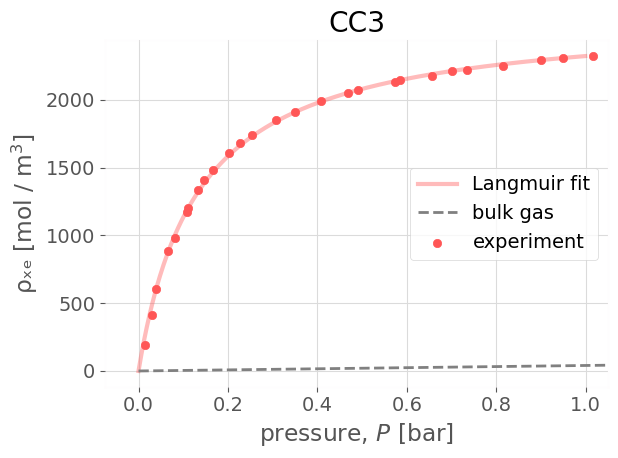

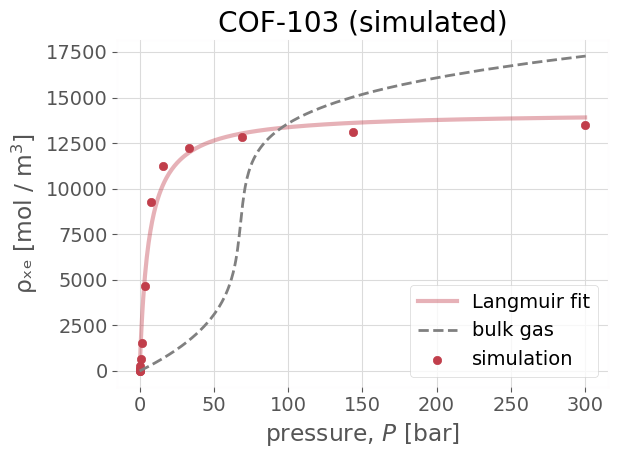

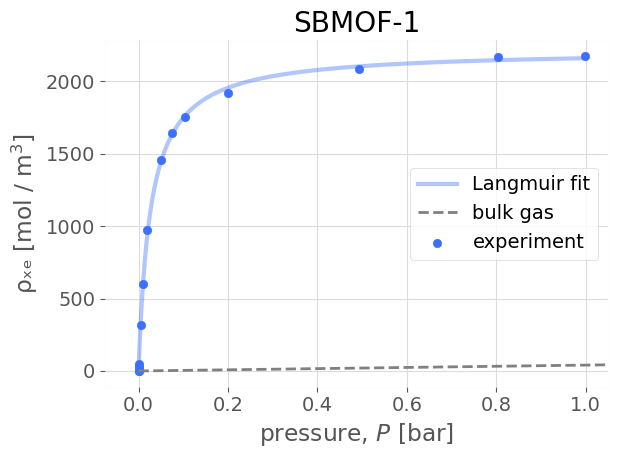

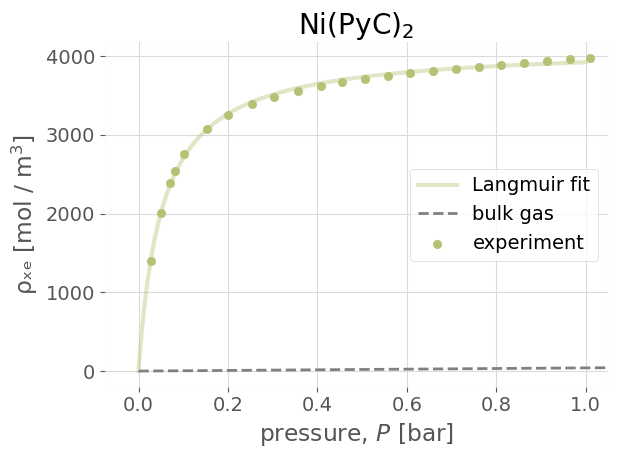

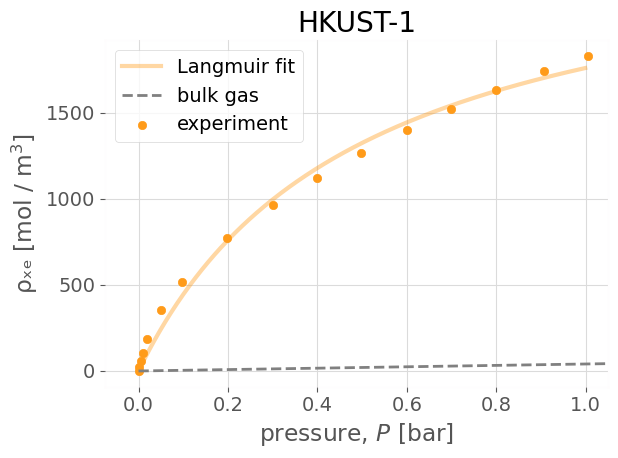

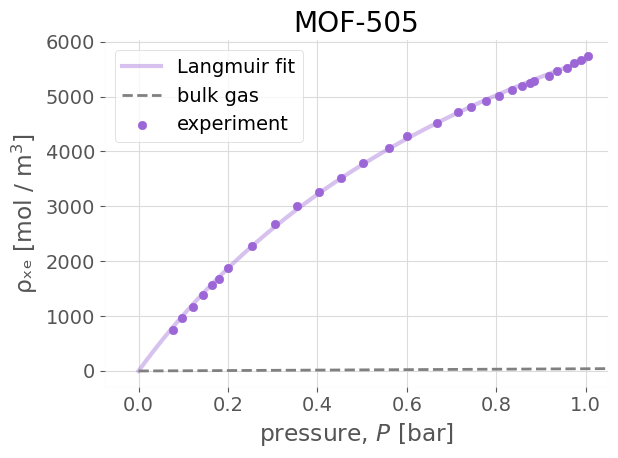

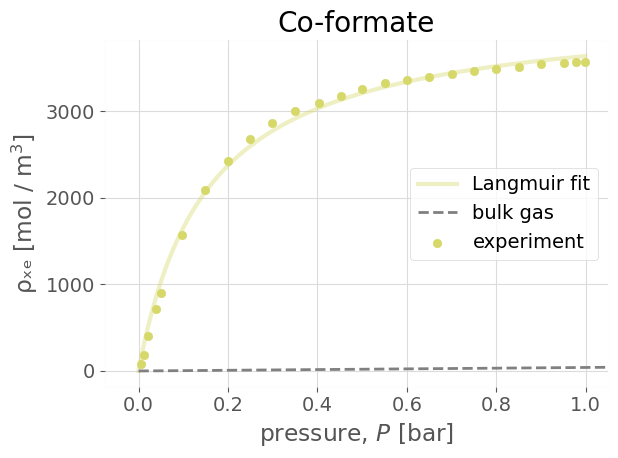

In [104]:
for xtal in keys(xe_isotherms)
    if xtal == "COF-103 (simulated)"
        plot_xtal_langmuir_fit(xtal, 299.999)
        savefig(string("figures/langmuir/low_P_langmuir_fit_", xtal, ".png"))        
    else
        plot_xtal_langmuir_fit(xtal, 0.999)
    end
end

### High pressure fit

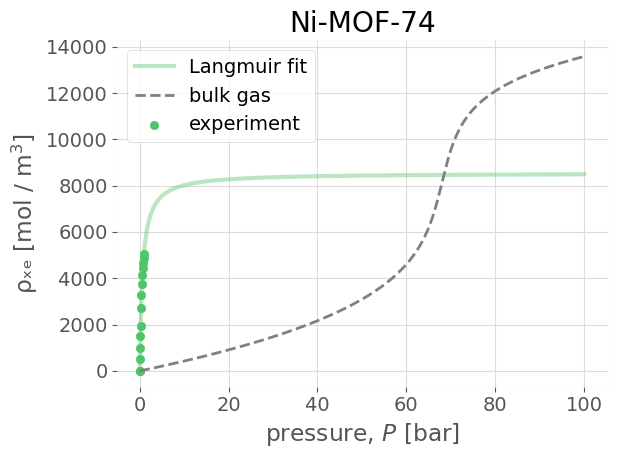

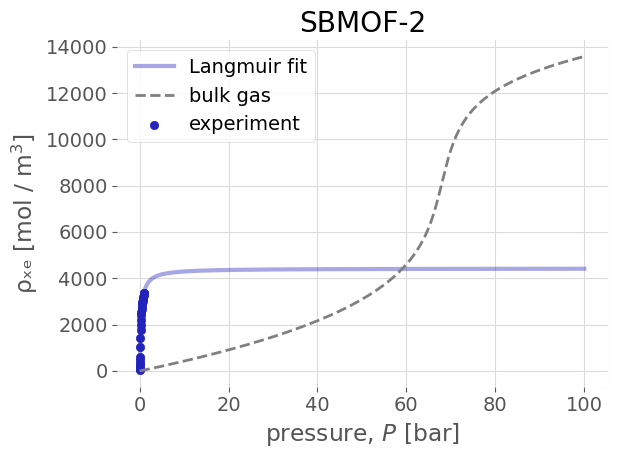

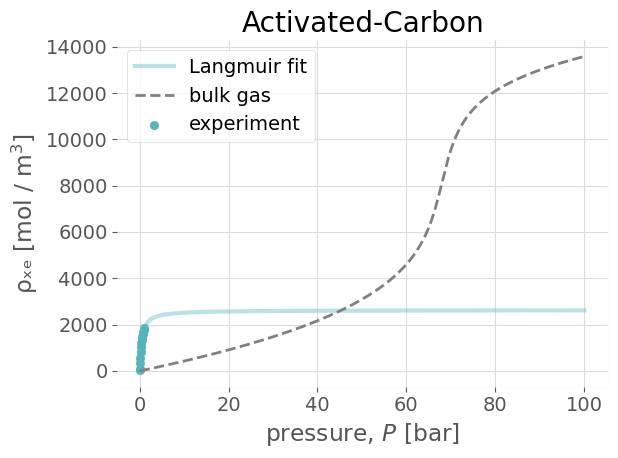

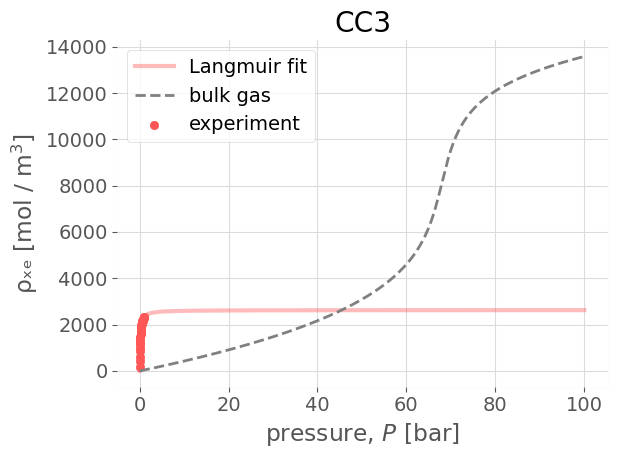

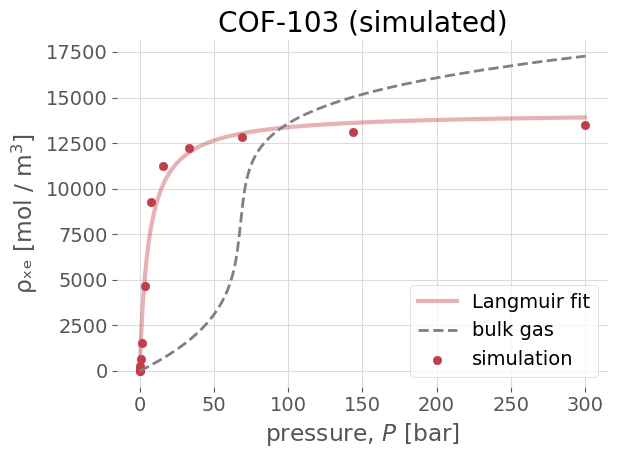

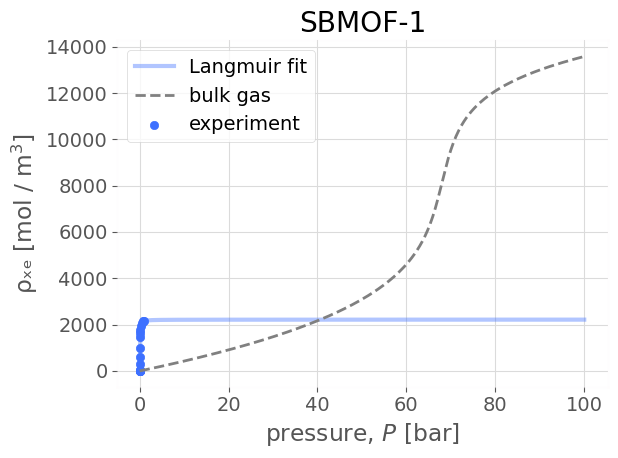

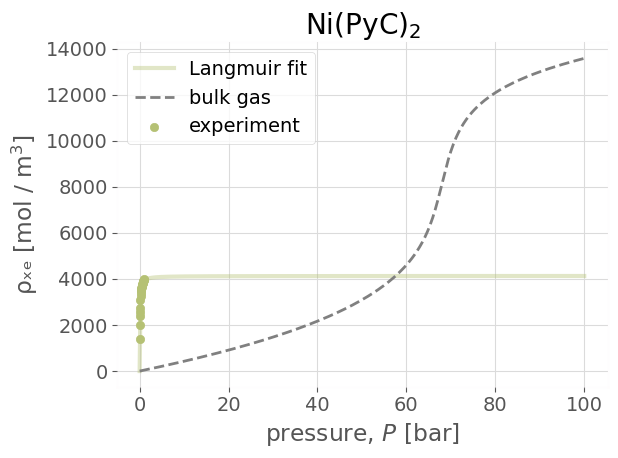

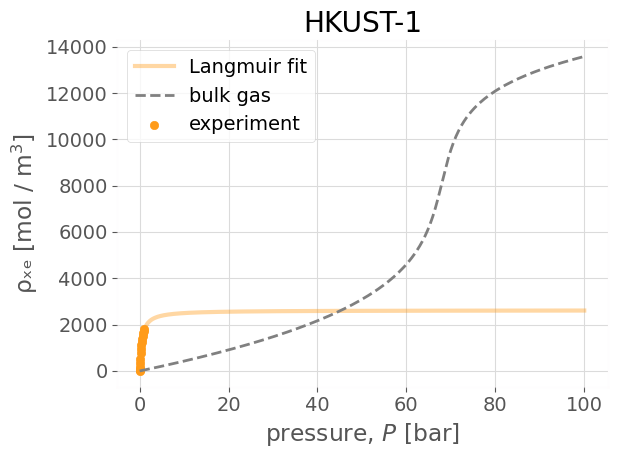

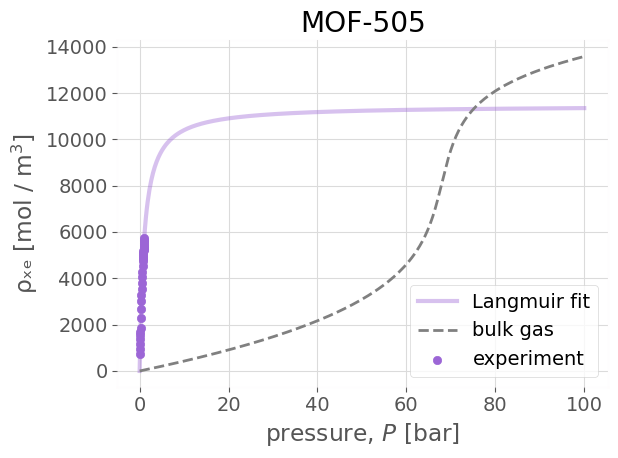

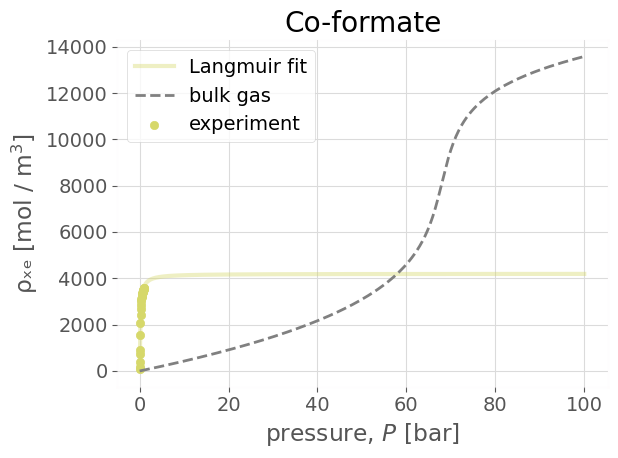

In [105]:
for xtal in keys(xe_isotherms)
    if xtal == "COF-103 (simulated)"
        plot_xtal_langmuir_fit(xtal, 300.0)
    else
        plot_xtal_langmuir_fit(xtal, 100.0)
    end
end